### Libraries

In [150]:
import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.metrics import confusion_matrix
from sklearn.cluster import AgglomerativeClustering



### Importing and orgenizing data 


In [132]:
columns = [
    "ID", "Diagnosis",
    "radius_mean", "texture_mean", "perimeter_mean", "area_mean", "smoothness_mean",
    "compactness_mean", "concavity_mean", "concave_points_mean", "symmetry_mean", "fractal_dimension_mean",
    "radius_se", "texture_se", "perimeter_se", "area_se", "smoothness_se",
    "compactness_se", "concavity_se", "concave_points_se", "symmetry_se", "fractal_dimension_se",
    "radius_worst", "texture_worst", "perimeter_worst", "area_worst", "smoothness_worst",
    "compactness_worst", "concavity_worst", "concave_points_worst", "symmetry_worst", "fractal_dimension_worst"
]

df = pd.read_csv(r"C:/project_2year/wdbc.data", header=None, names=columns)


### Cleaning Data

In [133]:

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       569 non-null    int64  
 1   Diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave_points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [134]:
#Checking for missing valuse
missing_columns = df.isnull().sum()
missing_columns = missing_columns[missing_columns > 0]
if not missing_columns.empty:
        print("Missing values found in the following columns:")
        print(missing_columns)
else:
    print("No missing values found in any column.")



No missing values found in any column.


In [135]:
# Find duplicated IDs
duplicated_ids = df[df['ID'].duplicated(keep=False)]
if not duplicated_ids.empty:
    print("Found duplicated ID numbers:")
    print(duplicated_ids.sort_values(by='ID'))
else:
    print("No duplicated ID numbers found.")

No duplicated ID numbers found.


### Drop diagnose and ID columns

In [136]:
data = df.drop(df.columns[[0, 1]], axis=1)



### Focus on Worst-Case Feature Values

We chose to focus primarily on the **third group of features**, which captures the distribution of worst-case values between malignant and benign tumors. This decision is based on clinical insights suggesting that **cancerous changes are more likely to appear in the extreme or most abnormal regions of tissue**, rather than in its average structure.  

As such, these "worst-case" features are expected to provide **more reliable and meaningful information** in our analysis, allowing us to identify a relevant subset of features for downstream clustering and interpretation.

#### Supporting Literature

Recent studies have confirmed the diagnostic and prognostic value of extreme feature measurements:

- **Brinkmann et al. (2023)** demonstrated that *maximum values* of texture and intensity were more effective than average metrics in tumor classification.  
- **Pilapil et al. (2023)** found that cells with *extreme morphological features* were more likely to exhibit aggressive, metastatic behavior.

These findings support our use of the `worst_*` columns from the WBCD dataset as the **most clinically informative features** for unsupervised clustering and further analysis.

**References:**
1. [Brinkmann et al., 2023 – NCBI](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10080822/)  
2. [Pilapil et al., 2023 – MDPI Cancers](https://www.mdpi.com/2072-6694/15/3/898)


In [137]:
def pick_columns(df,suffix):
 cols = [col for col in df.columns if col.endswith('_worst')]
 subset = df[cols]
 return subset

### HEATMAP

We generate a heatmap to identify highly correlated features. Features with strong correlation likely carry similar information, allowing us to reduce dimensionality manually by keeping only features with low mutual correlation.


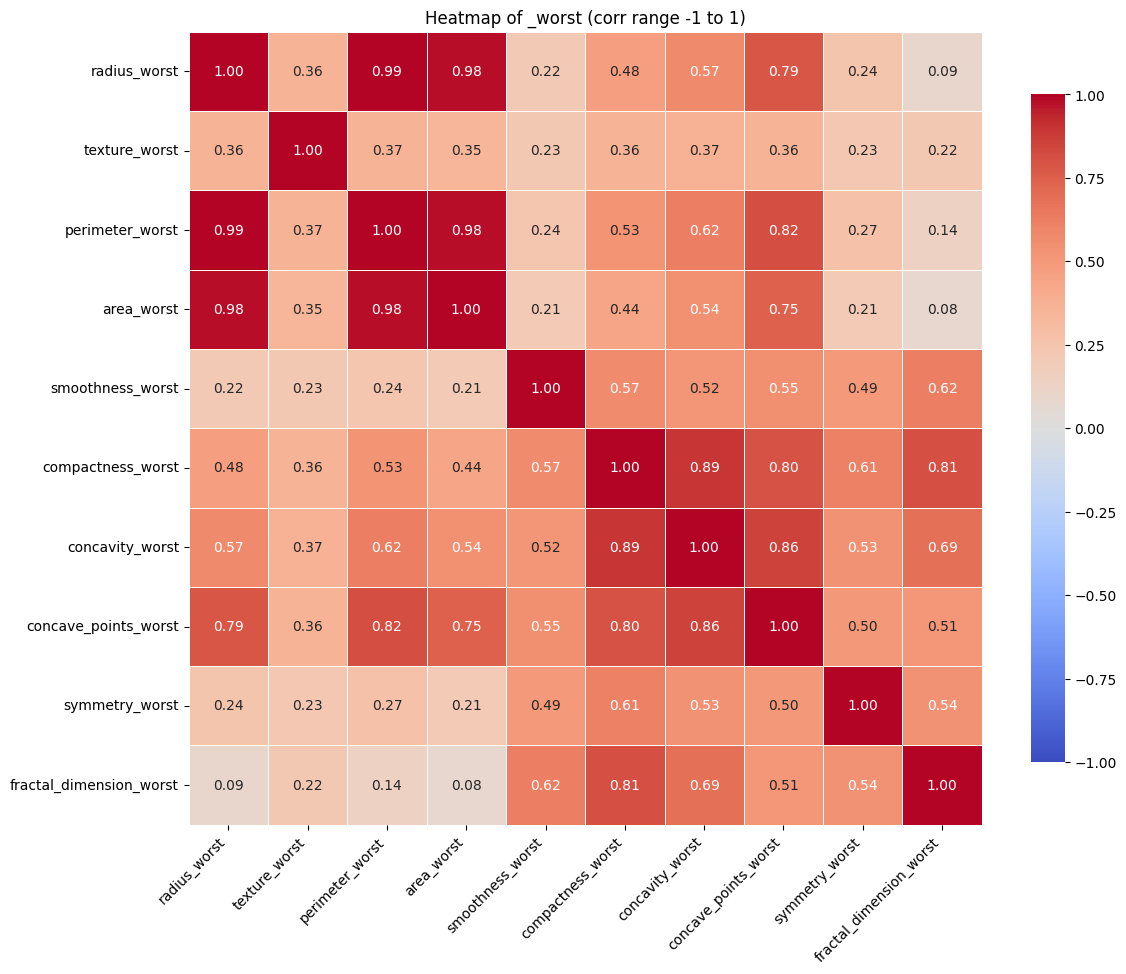

In [138]:
def heatmap(df, suffix):
    corr = df.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr,
        annot=True, fmt=".2f",
        cmap='coolwarm',
        vmin=-1, vmax=1,
        center=0,
        robust=True,
        linewidths=0.5,
        square=True,
        cbar_kws={'shrink': 0.8}
    )
    plt.title(f"Heatmap of {suffix} (corr range -1 to 1)")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
worst_col= pick_columns(data,'_worst')
heatmap(worst_col,'_worst')


### Heatmap Insights
We can observe a strong correlation between **radius**, **perimeter**, and **area**, so we will select only one of them. Similarly, **compactness**, **concavity**, and **concave points** are also highly correlated, allowing us to keep just one representative feature from this group.  
Thus, based solely on insights from the heatmap, we can reduce the feature space by removing 4 features.


### Normalizing the Data

Normalization is required before creating a pairplot, as the features have varying value ranges and scales.


In [139]:
scaler = StandardScaler()
normalized_data = scaler.fit_transform(worst_col)
normalized_worst_df = pd.DataFrame(normalized_data, columns=worst_col.columns)
print(normalized_worst_df.head())


   radius_worst  texture_worst  perimeter_worst  area_worst  smoothness_worst  \
0      1.886690      -1.359293         2.303601    2.001237          1.307686   
1      1.805927      -0.369203         1.535126    1.890489         -0.375612   
2      1.511870      -0.023974         1.347475    1.456285          0.527407   
3     -0.281464       0.133984        -0.249939   -0.550021          3.394275   
4      1.298575      -1.466770         1.338539    1.220724          0.220556   

   compactness_worst  concavity_worst  concave_points_worst  symmetry_worst  \
0           2.616665         2.109526              2.296076        2.750622   
1          -0.430444        -0.146749              1.087084       -0.243890   
2           1.082932         0.854974              1.955000        1.152255   
3           3.893397         1.989588              2.175786        6.046041   
4          -0.313395         0.613179              0.729259       -0.868353   

   fractal_dimension_worst  
0        

 ### PairPlot Exploration

As a complementary visualization to the heatmap, we use PairPlot to explore relationships between pairs of features.  
It helps us identify correlations, distribution patterns, and potential cluster structures within the data.
 

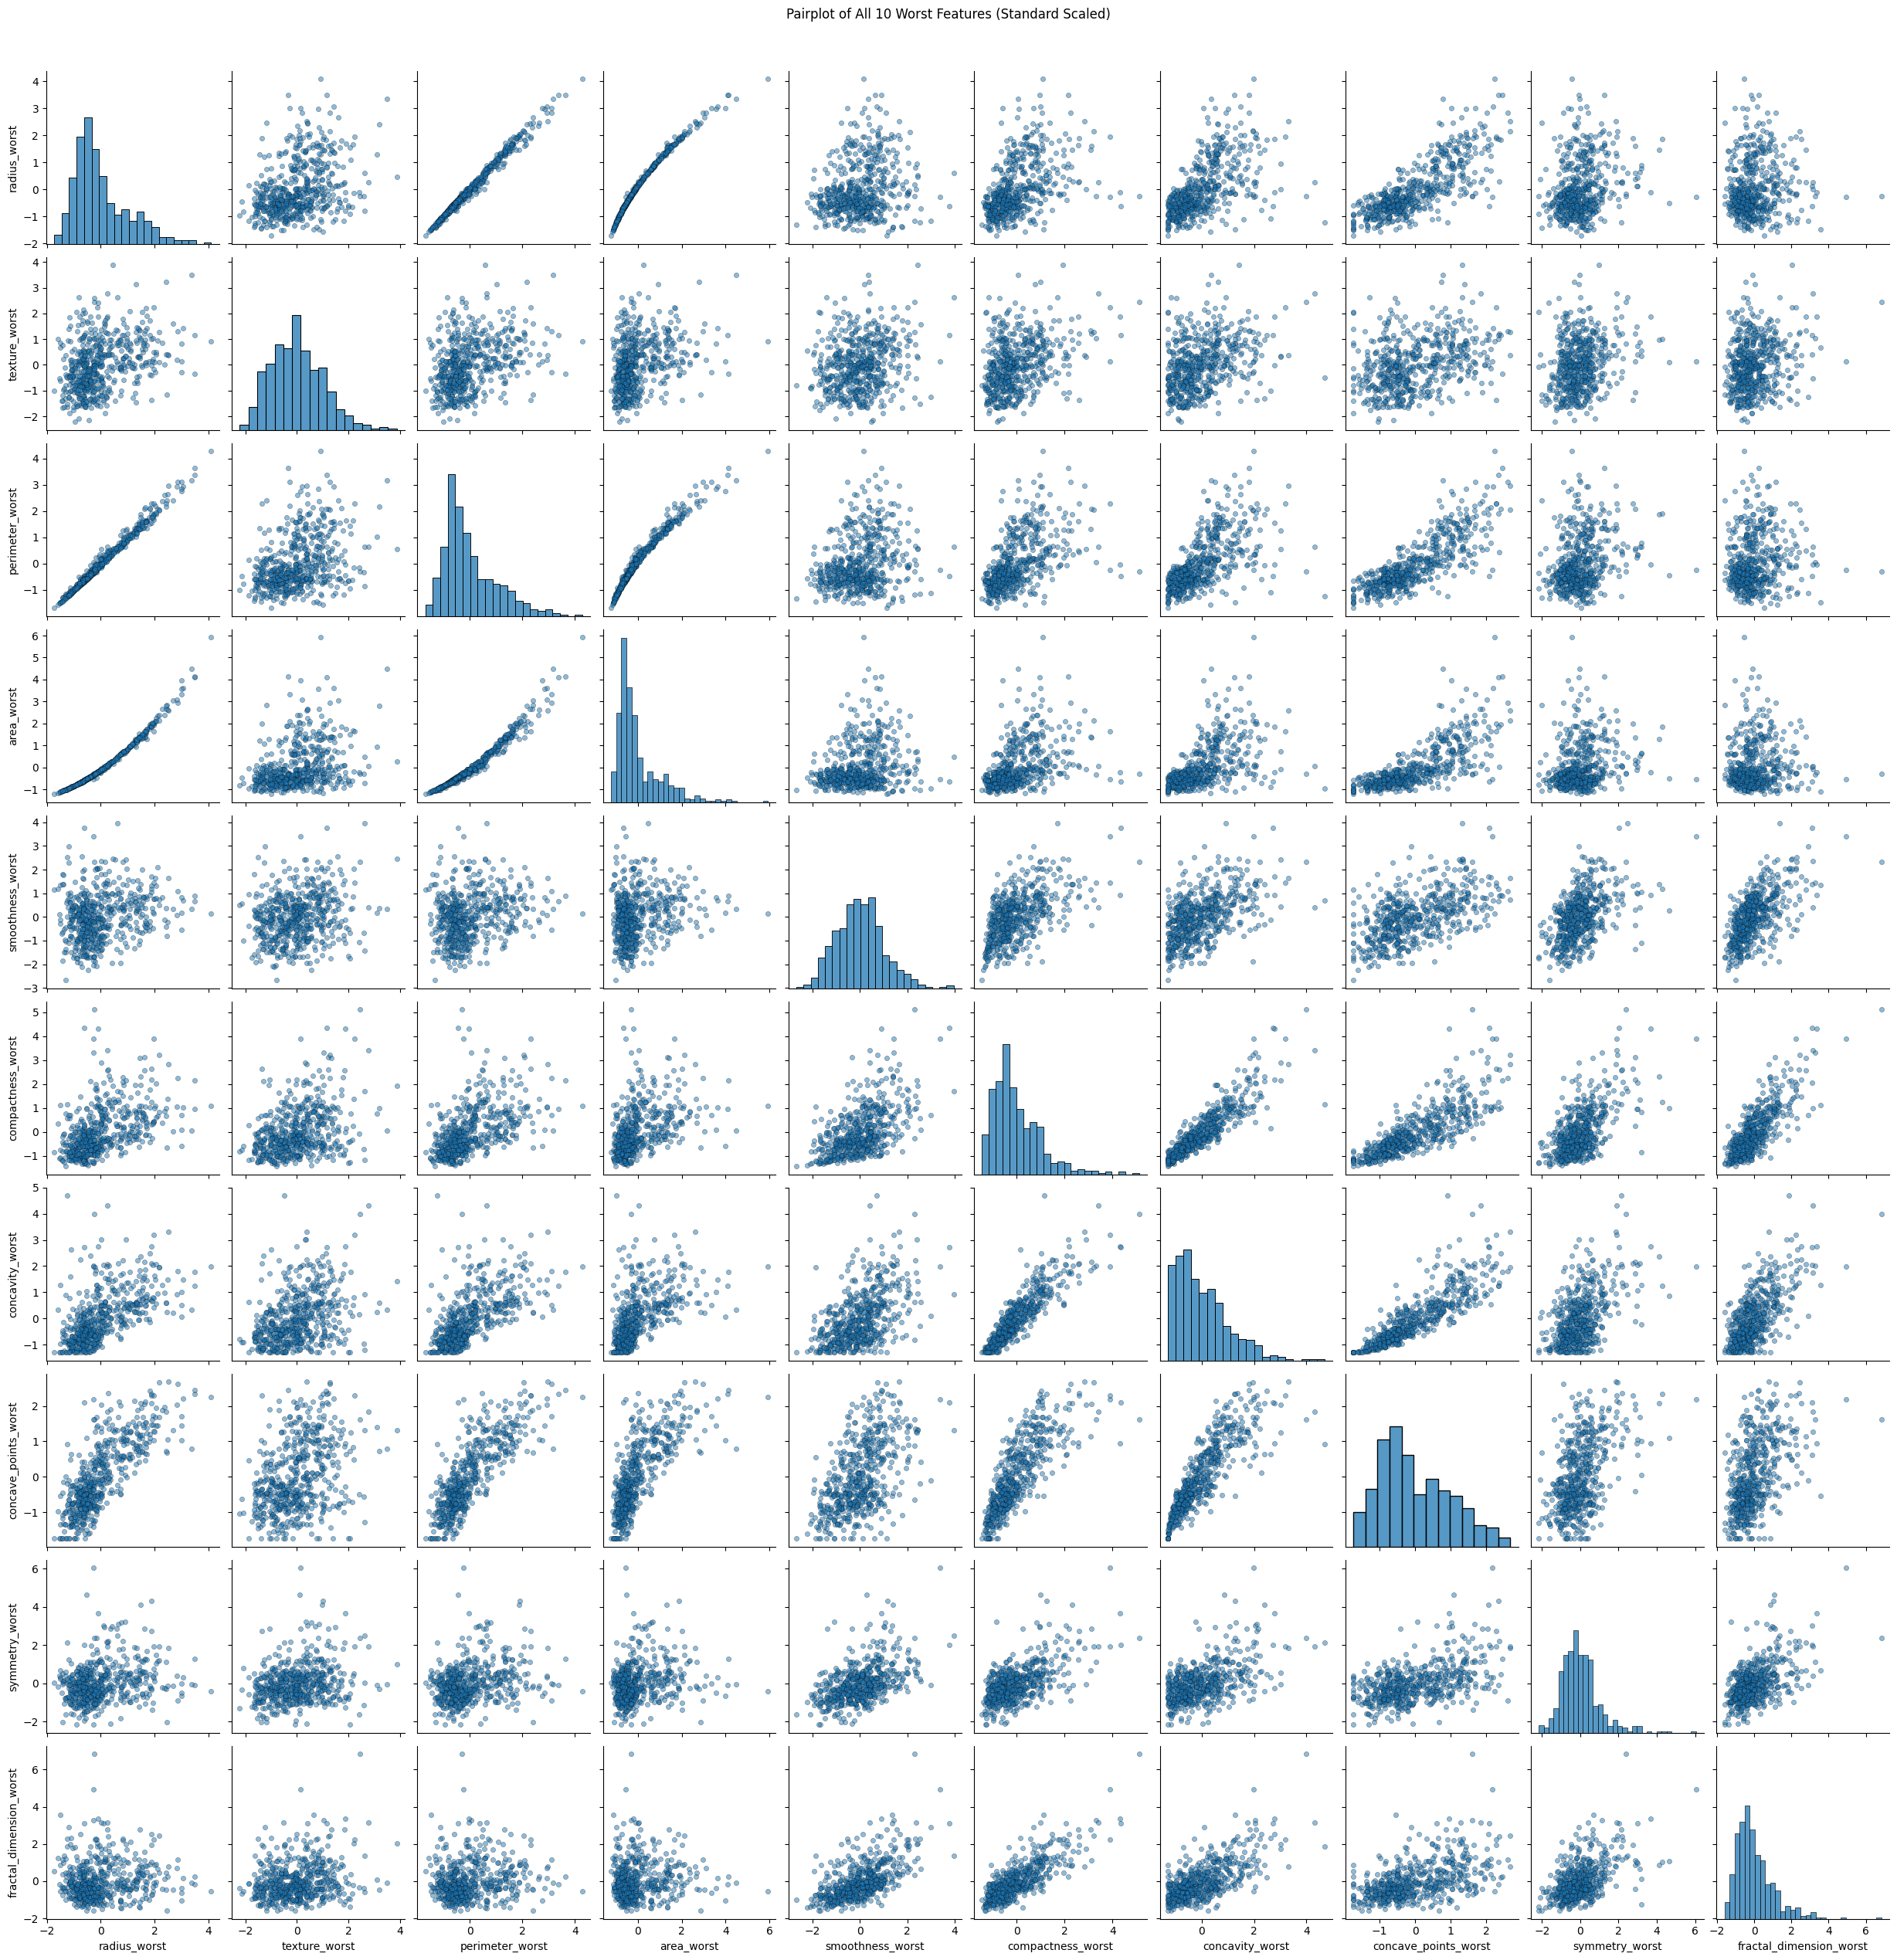

In [140]:
sns.pairplot(normalized_worst_df, plot_kws={"alpha": 0.5, "s": 20, "edgecolor": "k"})
plt.suptitle("Pairplot of All 10 Worst Features (Standard Scaled)", y=1.02)
plt.show()

### PairPlot Insights

Based on the pairplot, we selected five features that show clear variance and visual separation between potential clusters:

- `area_worst`  
- `concave_points_worst`  
- `fractal_dimension_worst`  
- `compactness_worst`  
- `texture_worst`

These features were chosen as they complement the insights from the heatmap and may enhance clustering effectiveness.



### PCA(Principal Component Analysis)

In [141]:
pca = PCA()
pca.fit(normalized_worst_df);




### Scree plot

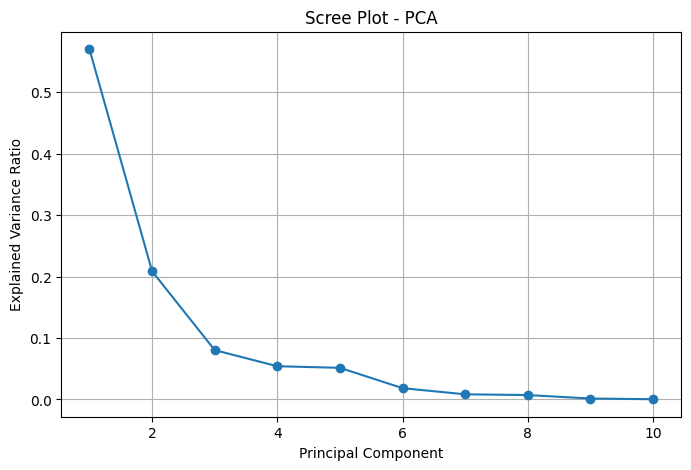

In [142]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot - PCA')
plt.grid(True)
plt.show()

### Scree Plot Insights

A clear "elbow" is observed in the scree plot, indicating that the first 2–3 principal components capture the majority of the variance. 

### Feature Loadings 
Based on Scree Plot Insights, we aim to identify the top 3 contributing features. These selected features will serve as the input for relevant clustering algorithms. 


Feature Loadings on PC1, PC2, and PC3:
                              PC1       PC2       PC3
radius_worst             0.335910 -0.403137 -0.076133
texture_worst            0.200731 -0.042572  0.976824
perimeter_worst          0.348151 -0.375518 -0.083820
area_worst               0.324739 -0.415256 -0.079022
smoothness_worst         0.248626  0.337870 -0.051443
compactness_worst        0.364568  0.250566 -0.038014
concavity_worst          0.374742  0.139085 -0.058555
concave_points_worst     0.397637 -0.041685 -0.132176
symmetry_worst           0.249753  0.308607 -0.021464
fractal_dimension_worst  0.254083  0.478495 -0.036015


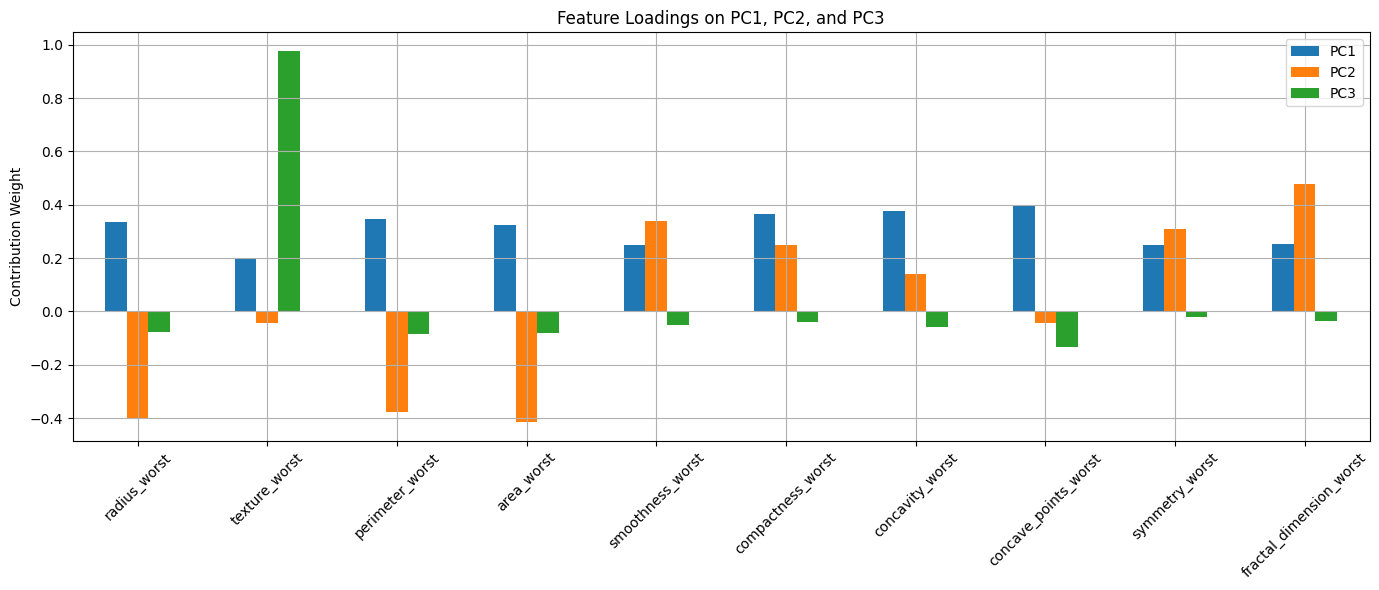

In [143]:
# Apply PCA with 3 components
pca = PCA(n_components=3)
pca.fit(normalized_worst_df)

# Extract loadings (feature contributions to each principal component)
loadings = pd.DataFrame(
    pca.components_.T,
    index=normalized_worst_df.columns,
    columns=['PC1', 'PC2', 'PC3']
)

# Print the loadings table
print("Feature Loadings on PC1, PC2, and PC3:")
print(loadings)

# Plot a bar chart of the loadings
loadings.plot(kind='bar', figsize=(14, 6))
plt.title("Feature Loadings on PC1, PC2, and PC3")
plt.ylabel("Contribution Weight")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### Final Feature Selection for Clustering

Based on the **PCA loadings**, we observed that certain features — specifically `area_worst`, `concave_points_worst`, and `compactness_worst` — had the highest contributions to the first three principal components.  
This suggests that these features capture the most significant variance in the dataset and are therefore highly informative.

By integrating these results with insights from the **heatmap**, which highlighted strong correlations between some features, and the **pairplot**, which visually revealed clear separation between patterns,  
we concluded that the following three features are the most suitable for clustering purposes.

**Selected features for clustering:**
- `area_worst`  
- `concave_points_worst`  
- `compactness_worst`

This selection reflects a balance of **high variance**, **low feature redundancy**, and **visual discriminative power**, making it a strong foundation for the next clustering steps.


### K-MEANS
Fast, simple baseline: with standardized numeric features and two dominant classes (benign vs malignant), the method quickly finds two spherical centroids that already align well with the medical labels.

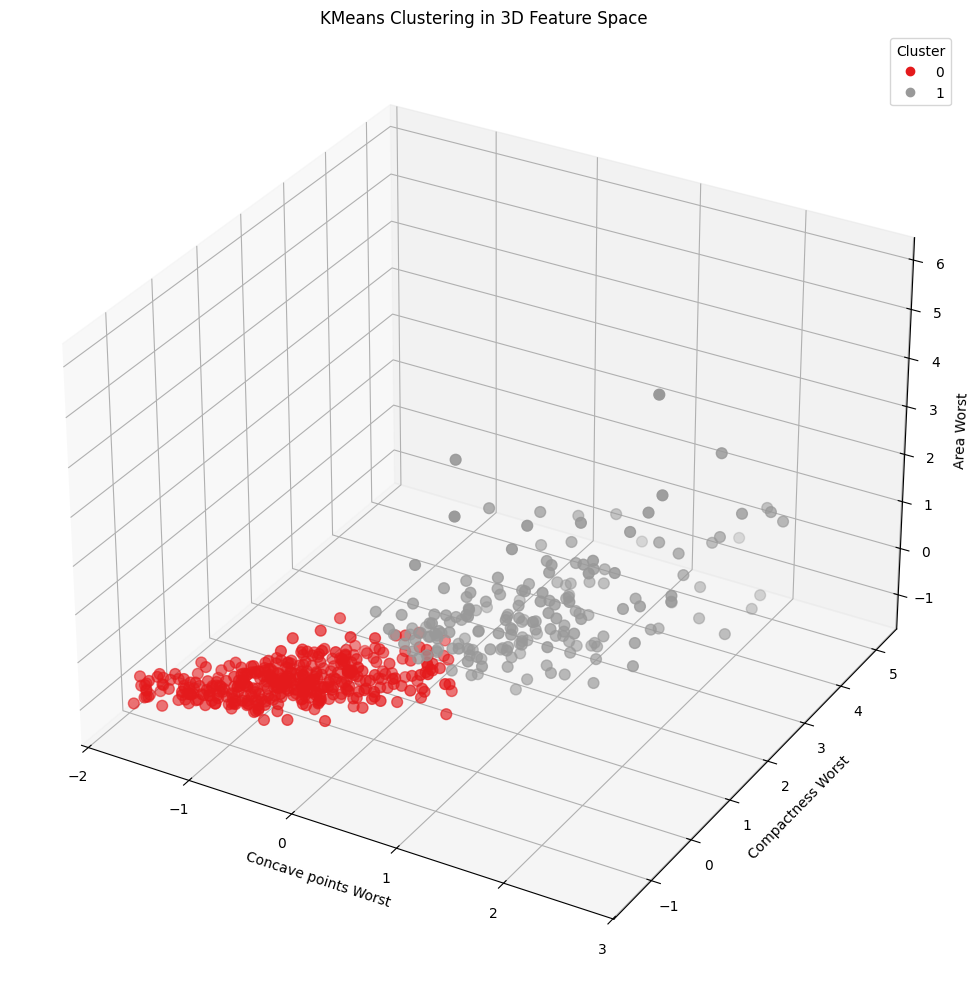

In [144]:


# Select the 3 features
selected_features = ['concave_points_worst', 'compactness_worst', 'area_worst']
selected_df = normalized_worst_df[selected_features].copy()

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=0)
selected_df['Cluster'] = kmeans.fit_predict(selected_df)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    selected_df['concave_points_worst'],
    selected_df['compactness_worst'],
    selected_df['area_worst'],
    c=selected_df['Cluster'],
    cmap='Set1',
    s=60
)

ax.set_xlabel('Concave points Worst')
ax.set_ylabel('Compactness Worst')
ax.set_zlabel('Area Worst')
ax.set_title('KMeans Clustering in 3D Feature Space')
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.tight_layout()
plt.show()


Silhouette score for K-means 

In [145]:
from sklearn.metrics import silhouette_score
X_worst = selected_df[['concave_points_worst', 'compactness_worst', 'area_worst']].values
labels_km = selected_df['Cluster'].values
km_sil = silhouette_score(X_worst, labels_km)
print(f" Silhouette score for K-Means (3 worst features): {km_sil:.4f}")


 Silhouette score for K-Means (3 worst features): 0.5369


### אחוז דיוק K-MEANS

In [ ]:
# Ensure numeric target column exists
if 'Diagnosis_Num' not in df.columns:
    df['Diagnosis_Num'] = df['Diagnosis'].map({'B': 0, 'M': 1})

# Add KMeans cluster labels to DataFrame
df['KMeans_Cluster'] = selected_df['Cluster']
cm = confusion_matrix(df['Diagnosis_Num'], df['KMeans_Cluster'])
cm_flipped = confusion_matrix(df['Diagnosis_Num'], 1 - df['KMeans_Cluster'])

acc = (df['Diagnosis_Num'] == df['KMeans_Cluster']).mean()
acc_flipped = (df['Diagnosis_Num'] == (1 - df['KMeans_Cluster'])).mean()
# Choose the better alignment
if acc > acc_flipped:
    best_cm, best_acc, note = cm, acc, "No label flipping"
else:
    best_cm, best_acc, note = cm_flipped, acc_flipped, "Labels flipped"
# Display results
print("Confusion Matrix between K-Means Clusters and Diagnosis:")
print(pd.DataFrame(best_cm, index=['Benign (0)', 'Malignant (1)'], columns=['Cluster 0', 'Cluster 1']))
print(f"\nOverall Accuracy: {best_acc:.2%}")
print(f"Note: {note}")



Confusion Matrix between K-Means Clusters and Diagnosis:
               Cluster 0  Cluster 1
Benign (0)           348          9
Malignant (1)         33        179

Overall Accuracy: 92.62%
Note: No label flipping


תצוגה נוספת

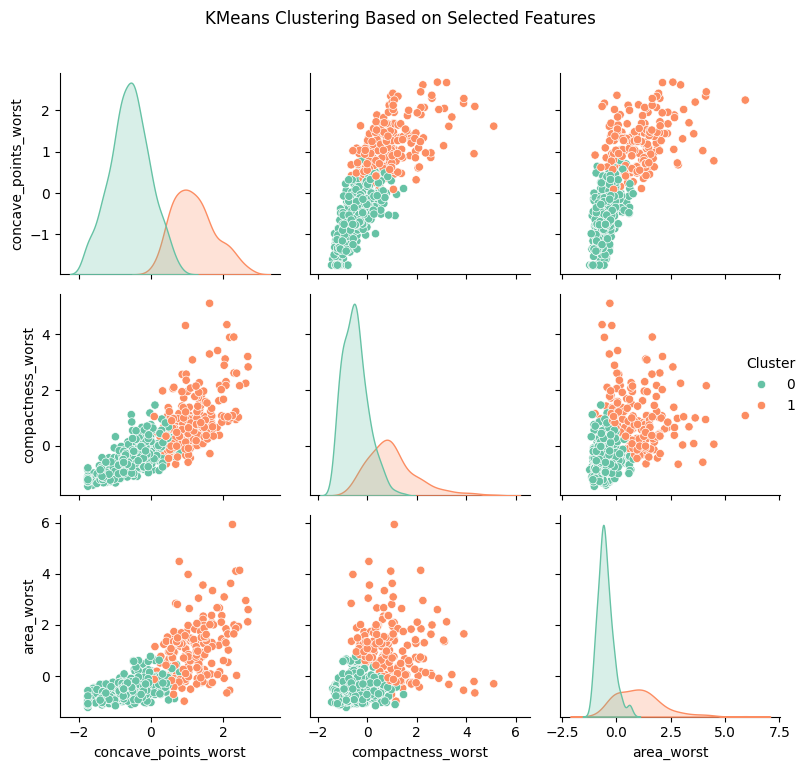

In [85]:
# Pairplot to visualize clusters
sns.pairplot(selected_df, hue='Cluster', diag_kind='kde', palette='Set2')
plt.suptitle("KMeans Clustering Based on Selected Features", y=1.02)
plt.tight_layout()
plt.show()

### DBSCAN 
	Density-based: can flag scattered outliers or “borderline” points as noise and keeps only the dense tumor vs. non-tumor cores, useful for spotting unusual or ambiguous cases.
	

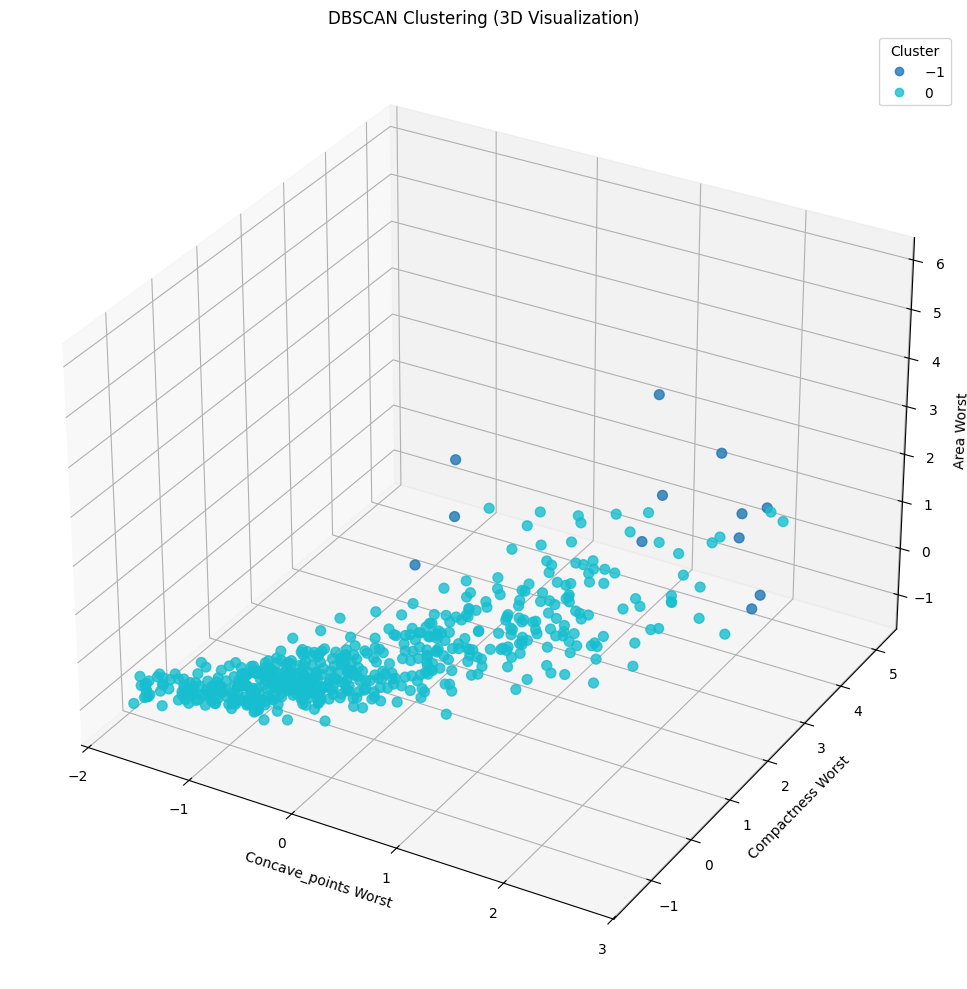

In [151]:
# Select features for clustering
selected_features = ['concave_points_worst', 'compactness_worst', 'area_worst']
selected_df = normalized_worst_df[selected_features]

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(selected_df)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.9, min_samples=5)
dbscan_labels = dbscan.fit_predict(scaled_data)

# Add labels to the DataFrame
selected_df_with_dbscan = selected_df.copy()
selected_df_with_dbscan['Cluster'] = dbscan_labels

# Plot 3D scatter plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    selected_df_with_dbscan['concave_points_worst'],
    selected_df_with_dbscan['compactness_worst'],
    selected_df_with_dbscan['area_worst'],
    c=selected_df_with_dbscan['Cluster'],
    cmap='tab10',
    s=50,
    alpha=0.8
)

ax.set_xlabel('Concave_points Worst')
ax.set_ylabel('Compactness Worst')
ax.set_zlabel('Area Worst')
ax.set_title('DBSCAN Clustering (3D Visualization)')

plt.legend(*scatter.legend_elements(), title="Cluster")
plt.tight_layout()
plt.show()



Silhouette score for DBSCAN 

In [ ]:
X = selected_df[['concave_points_worst',
                 'compactness_worst',
                 'area_worst']].values
X = StandardScaler().fit_transform(X)

db_labels = DBSCAN(eps=0.9, min_samples=5).fit_predict(X)

try:
    sil = silhouette_score(X, db_labels)
except ValueError:     
    sil = math.nan         
print(f"Silhouette score for DBSCAN : {sil}")




Silhouette score for DBSCAN : 0.5704295383642879




**Although we obtained a high Silhouette score, it does not necessarily indicate that the division into two clusters is actually good, as can be seen in the visual graph.**


### GMM(Gaussian Mixture Models) 
Handles elliptical clusters with different variances—matching the tight malignant cloud vs the spread-out benign cloud—and yields soft membership probabilities for borderline lesions.

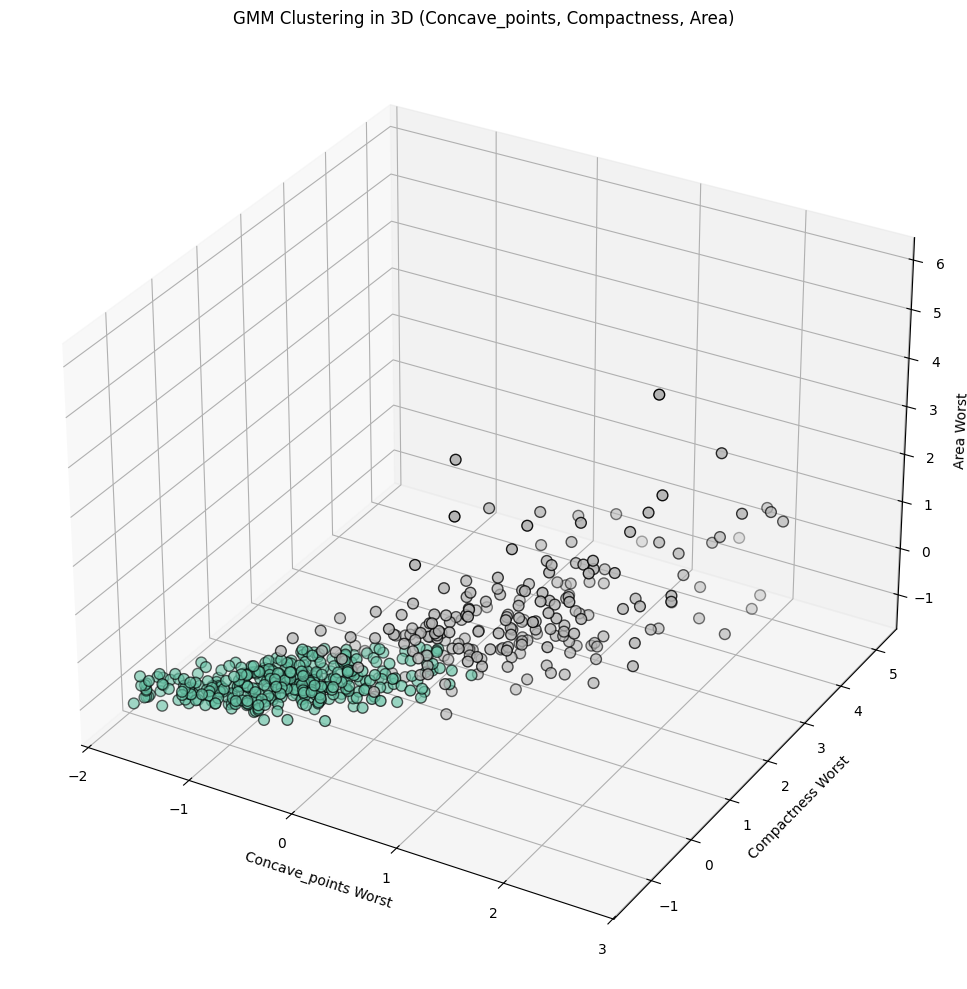

In [ ]:
# Select the three chosen features
selected_features = ['concave_points_worst', 'compactness_worst', 'area_worst']
selected_df = normalized_worst_df[selected_features]

# Apply Gaussian Mixture Model (GMM) with 2 clusters
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(selected_df)

# Predict hard cluster assignments
gmm_labels = gmm.predict(selected_df)

# Add cluster labels to the DataFrame
selected_df_with_gmm = selected_df.copy()
selected_df_with_gmm['GMM_Cluster'] = gmm_labels
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    selected_df_with_gmm['concave_points_worst'],
    selected_df_with_gmm['compactness_worst'],
    selected_df_with_gmm['area_worst'],
    c=selected_df_with_gmm['GMM_Cluster'],
    cmap='Set2',
    s=60,
    edgecolor='k'
)

ax.set_xlabel('Concave_points Worst')
ax.set_ylabel('Compactness Worst')
ax.set_zlabel('Area Worst')
ax.set_title('GMM Clustering in 3D (Concave_points, Compactness, Area)')
plt.tight_layout()
plt.show()


Silhouette score for GMM

In [159]:

X_worst = selected_df[['concave_points_worst', 'compactness_worst', 'area_worst']].values 
labels_gmm = gmm_labels          
gmm_sil = silhouette_score(X_worst, labels_gmm)
print(f" Silhouette score for GMM (3 worst features): {gmm_sil:.4f}")


 Silhouette score for GMM (3 worst features): 0.5026


אחוז דיוק הנוכחי GMM

In [160]:
df['Diagnosis_Num'] = df['Diagnosis'].map({'B': 0, 'M': 1})
# Add GMM cluster results to the original dataframe
df['GMM_Cluster'] = gmm_labels
# Compute confusion matrix
conf_mat = confusion_matrix(df['Diagnosis_Num'], df['GMM_Cluster'])
conf_mat_flipped = confusion_matrix(df['Diagnosis_Num'], 1 - df['GMM_Cluster'])

# Compute accuracies
accuracy = (df['Diagnosis_Num'] == df['GMM_Cluster']).mean()
accuracy_flipped = (df['Diagnosis_Num'] == (1 - df['GMM_Cluster'])).mean()

# Choose the better alignment
if accuracy > accuracy_flipped:
    best_conf_mat = conf_mat
    best_accuracy = accuracy
    note = "No label flipping"
else:
    best_conf_mat = conf_mat_flipped
    best_accuracy = accuracy_flipped
    note = "Labels flipped for better alignment"

print(" Confusion Matrix between GMM Clusters and Diagnosis:")
print(pd.DataFrame(best_conf_mat, index=['Benign (0)', 'Malignant (1)'], columns=['Cluster 0', 'Cluster 1']))
print(f"\nOverall Accuracy: {best_accuracy:.2%}")
print(f"Note: {note}")


 Confusion Matrix between GMM Clusters and Diagnosis:
               Cluster 0  Cluster 1
Benign (0)           336         21
Malignant (1)         22        190

Overall Accuracy: 92.44%
Note: No label flipping


### Agglomerative Clustering
Builds a full hierarchy, letting you reveal sub-clusters inside benign or malignant groups; Ward’s criterion mimics K-Means but shows where a third or fourth cluster may split off.

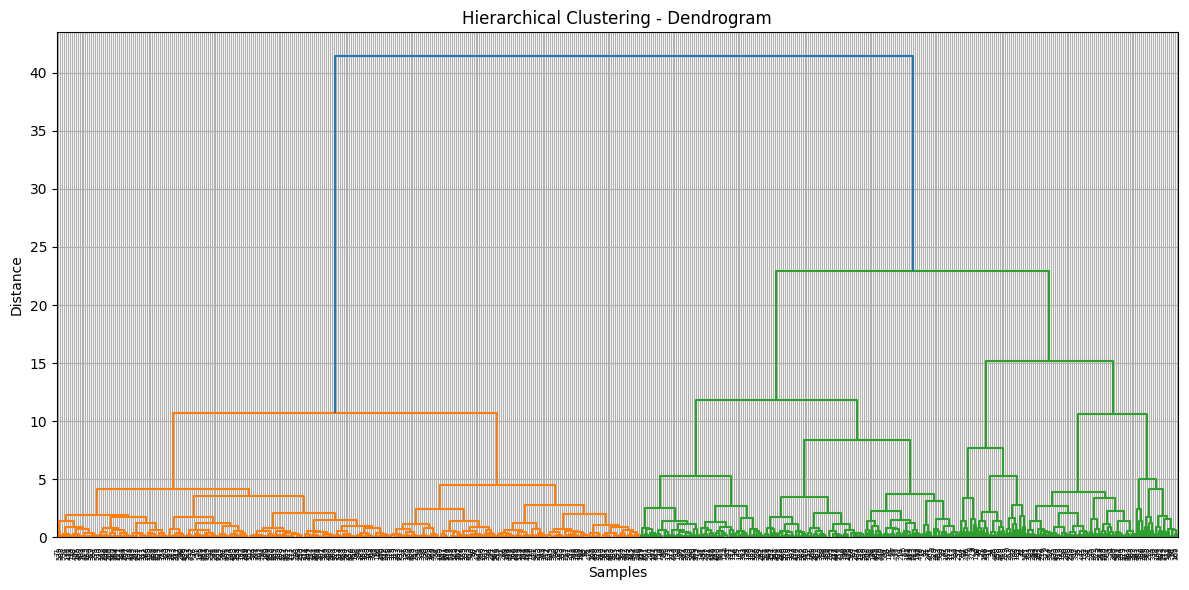

In [161]:
selected_features = ['concave_points_worst', 'compactness_worst', 'area_worst']
selected_df = normalized_worst_df[selected_features].copy()

#Compute linkage matrix for dendrogram
linkage_matrix = sch.linkage(selected_df, method='ward')

#Plot dendrogram
plt.figure(figsize=(12, 6))
sch.dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering - Dendrogram")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.grid(True)
plt.tight_layout()
plt.show()

#Apply Agglomerative Clustering with 2 clusters
hierarchical = AgglomerativeClustering(n_clusters=2, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(selected_df)
selected_df['Cluster'] = hierarchical_labels



> We added a red line to indicate the dendrogram cut level.


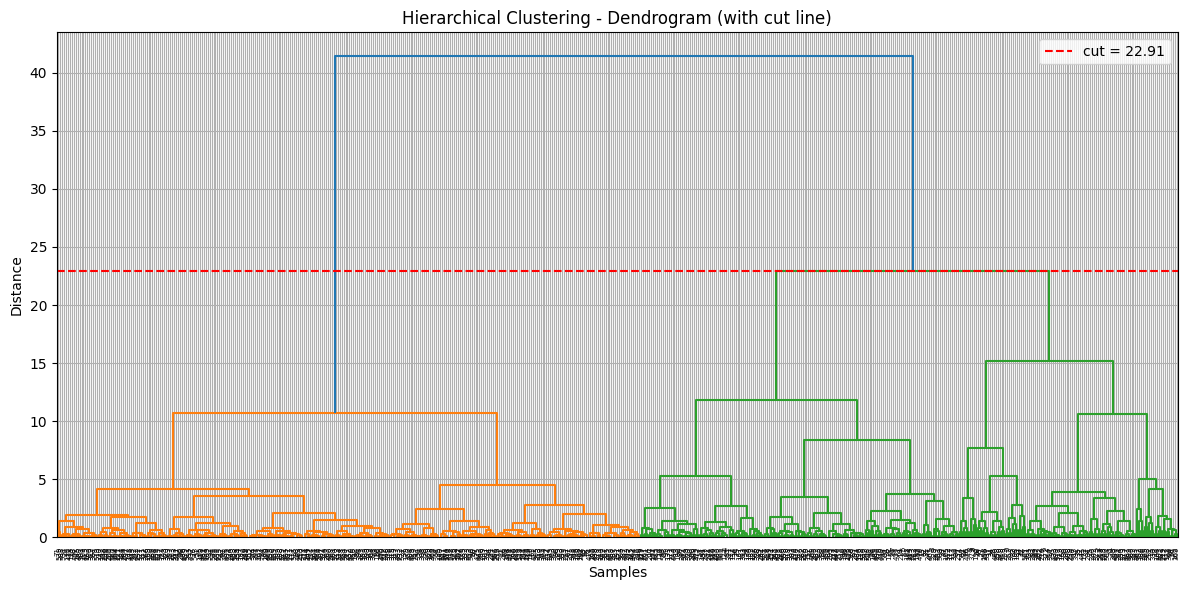

In [176]:
cut_height = linkage_matrix[-2, 2]
plt.figure(figsize=(12, 6))
sch.dendrogram(linkage_matrix)
plt.axhline(y=cut_height, color='red', linestyle='--', lw=1.5, label=f'cut = {cut_height:.2f}')  
plt.title("Hierarchical Clustering - Dendrogram (with cut line)")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



 Silhouette score for Agglomerative

In [167]:
X_worst = selected_df[['concave_points_worst', 'compactness_worst', 'area_worst']].values   
# run Agglomerative (Ward linkage, 2 clusters)
agg = AgglomerativeClustering(n_clusters=2, linkage='ward')
agg_labels = agg.fit_predict(X_worst)          
sil = silhouette_score(X_worst, agg_labels)
print(f" Silhouette score for Agglomerative: {sil:.4f}")


 Silhouette score for Agglomerative: 0.4480


בדיקת אחוזי דיוק

In [168]:
# Map original diagnosis to numeric labels
df['Diagnosis_Num'] = df['Diagnosis'].map({'B': 0, 'M': 1})

# Compute accuracy and confusion matrix (including flip check)
acc1 = (df['Diagnosis_Num'] == hierarchical_labels).mean()
acc2 = (df['Diagnosis_Num'] == (1 - hierarchical_labels)).mean()

if acc1 > acc2:
    final_labels = hierarchical_labels
    note = "No label flip"
    acc = acc1
else:
    final_labels = 1 - hierarchical_labels
    note = "Cluster labels flipped"
    acc = acc2

conf_mat = confusion_matrix(df['Diagnosis_Num'], final_labels)

# Print results
print("Confusion Matrix (Hierarchical vs Diagnosis):")
print(pd.DataFrame(conf_mat, index=['Benign (0)', 'Malignant (1)'], columns=['Cluster 0', 'Cluster 1']))
print(f"\n Accuracy: {acc:.2%}")
print(f" Note: {note}")


Confusion Matrix (Hierarchical vs Diagnosis):
               Cluster 0  Cluster 1
Benign (0)           291         66
Malignant (1)          5        207

 Accuracy: 87.52%
 Note: Cluster labels flipped


### Silhouette Score Comparison

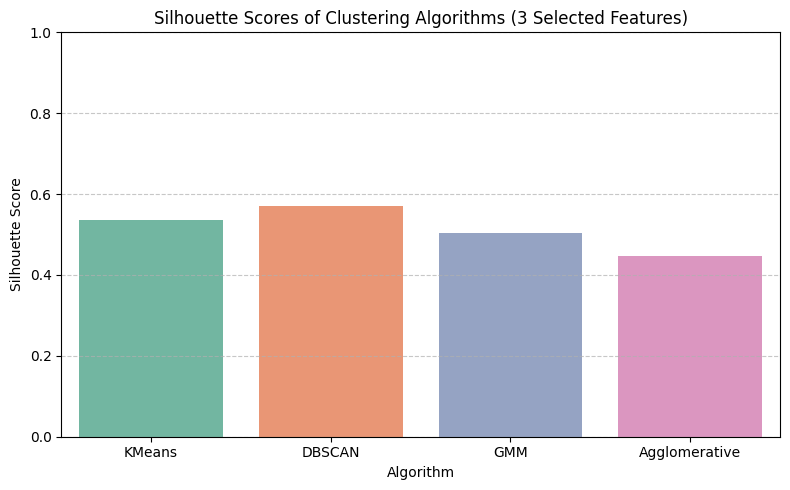

In [173]:
selected_features = ['concave_points_worst', 'compactness_worst', 'area_worst']
X = selected_df[selected_features].values
X = StandardScaler().fit_transform(X)
silhouette_scores = {}

# KMeans
kmeans_labels = KMeans(n_clusters=2, random_state=0).fit_predict(X)
silhouette_scores['KMeans'] = silhouette_score(X, kmeans_labels)

# DBSCAN
db_labels = DBSCAN(eps=0.9, min_samples=5).fit_predict(X)
try:
    silhouette_scores['DBSCAN'] = silhouette_score(X, db_labels)
except ValueError:
    silhouette_scores['DBSCAN'] = math.nan  # במידה ויש רק קלאסטר אחד

# GMM
gmm_labels = GaussianMixture(n_components=2, random_state=0).fit(X).predict(X)
silhouette_scores['GMM'] = silhouette_score(X, gmm_labels)

# Agglomerative Clustering
agg_labels = AgglomerativeClustering(n_clusters=2).fit_predict(X)
silhouette_scores['Agglomerative'] = silhouette_score(X, agg_labels)
score_df = pd.DataFrame(list(silhouette_scores.items()), columns=['Algorithm', 'Silhouette Score'])

plt.figure(figsize=(8, 5))
sns.barplot(data=score_df, x='Algorithm', y='Silhouette Score', hue='Algorithm', palette='Set2', legend=False)
plt.title('Silhouette Scores of Clustering Algorithms (3 Selected Features)')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



### Clustering Accuracy Comparison

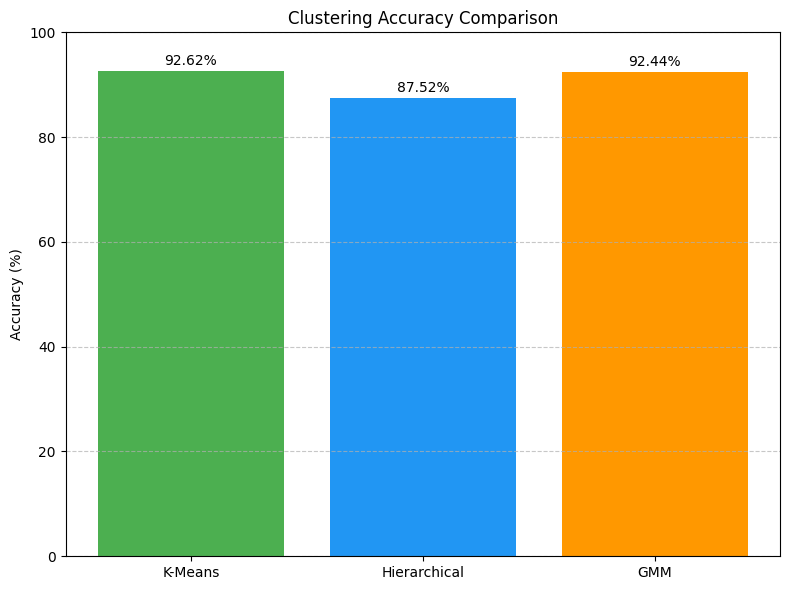

In [175]:
methods = ['K-Means', 'Hierarchical', 'GMM']
accuracies = [92.62, 87.52, 92.44]

# Define custom colors for each bar
colors = ['#4CAF50', '#2196F3', '#FF9800']  # Green, Blue, Orange
plt.figure(figsize=(8, 6))
bars = plt.bar(methods, accuracies, color=colors)

# Add text labels on top of bars
for bar, acc in zip(bars, accuracies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{acc:.2f}%', ha='center', va='bottom')

# Chart formatting
plt.ylim(0, 100)
plt.ylabel('Accuracy (%)')
plt.title('Clustering Accuracy Comparison')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
